In [1]:
import tensorflow as tf
print('GPU Readiness:\n','‚Äî'*20,sep='')
print('‚úÖ Built with CUDA' if tf.test.is_built_with_cuda() else 'üõë Built without CUDA')
print('‚úÖ NVIDIA GPU Available' if tf.test.is_gpu_available(cuda_only=True) else 'üõë NVIDIA GPU Unavailable')
print(f'\nGPU Identifier: {tf.test.gpu_device_name()}')

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


GPU Readiness:
‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
‚úÖ Built with CUDA
‚úÖ NVIDIA GPU Available

GPU Identifier: /device:GPU:0


In [62]:
from itertools import product
from PIL import Image, ImageOps

import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
plt = matplotlib.pyplot

%matplotlib inline

sns.set_style('whitegrid')

matplotlib.rcParams.update({'figure.figsize': (10, 6)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})

%config InlineBackend.figure_format = 'retina'

In [3]:
image_size = (50, 50)

In [14]:
import os.path

def generate_dataset_archive(overwrite=False):
    '''
    load all images data/cat.{i}.jpg and data/dog.{i}.jpg
    for i in 0...12499 inclusive, then downscale to
    image_size and archive as a compressed .npz file.
    
    expects you to have extracted the dogs vs. cats
    dataset from kaggle into a folder underneath this
    notebook called data. it consists of 25000 JPEG images.
    '''    
    archive_name = 'dogs_vs_cats.npz'
    file_prefix = 'data/'
    PIL_GRAYSCALE_MODE = 'L'
    images = []
    labels = []
    
    archive_exists = os.path.isfile(archive_name)
    if not overwrite and archive_exists:
        print(f'The archive file {archive_name} already exists. Skipping data processing.')
        return
    elif overwrite and archive_exists:
        print('Processing data and overwriting to archive file...')
    else:
        print('Processing data and creating new archive file...')
    
    for pet_type, index in product(['cat','dog'], range(12500)):
        file_name = f'{pet_type}.{index}'
        image = Image.open(f'{file_prefix}{file_name}.jpg').convert(mode=PIL_GRAYSCALE_MODE)
        image = ImageOps.fit(image, image_size, method=Image.ANTIALIAS)
        data = np.array(image.getdata())
        
        is_dog = (pet_type == 'dog')
        images.append(data)
        labels.append(is_dog)
    
    # numpy archive (.npz) of multiple objects
    np.savez_compressed(
        archive_name, 
        data=np.array(images,dtype=np.uint8), 
        target=np.array(labels,dtype=np.bool_)
    )

def normalize_scalar(x):
    '''
    map the integer range 0...255
    to the float32 range -1.0...1.0
    '''
    return 2*((x/255)-0.5)
normalize = np.vectorize(normalize_scalar, otypes=[np.float32])
    
def flip_bitmap(data):
    data = data.reshape(image_size)
    data = np.fliplr(data)
    return data.flatten()
flip_all_images = np.vectorize(flip_bitmap, otypes=[np.float32])
    
def flip_dataset(data,target):
    data_flipped = np.copy(data)
    data_flipped = np.apply_along_axis(flip_bitmap, 1, data_flipped)
    return np.vstack((data,data_flipped)), np.concatenate((target,target))

def load_dataset_archive(sample=None, flip=False):
    '''
    pick a random sample from the total population of images.
    create horizontally mirrored duplicates of all source images
    if requested.
    '''
    
    archive_name = 'dogs_vs_cats.npz'
    ds = np.load(archive_name)
    
    image_count = ds["data"].shape[0]
    print(f'Loaded archive with a total of {image_count} images.')
    
    if sample is None:
        print(f'No sampling - using full dataset ({image_count} images)')
        data = ds['data']
        target = ds['target']
    
    elif 0.0 > sample < 1.0:
        raise ValueError('Sample rate must be between 0 and 1')
        
    elif sample is not None:
        sample_count = int(sample * image_count)
        if sample_count == 0:
            raise ValueError(f'A sample rate of {sample} yields a zero-sized sample!')
        print(f'Randomly sampling {sample*100:1.2}% of the dataset ({sample_count}/{image_count})')
        sample = random.sample(range(max_images_per_class), min(max_images_per_class,images_per_class))
        data = ds['data'][sample]
        target = ds['target'][sample]
        
    if flip: 
        print(f'Flipping to double dataset ({image_count*2} images)')
        data, target = flip_dataset(data, target)
    
    return data, target

In [15]:
%%time
# Loading the whole dataset from individual image files
# (25,000 images total) is very slow. This function
# generates a numpy archive (.npz) of the downsized grayscale
# images if it doesn't already exist. This saves time when
# rerunning the notebook.
generate_dataset_archive()

The archive file dogs_vs_cats.npz already exists. Skipping data processing.
CPU times: user 64 ¬µs, sys: 2 ¬µs, total: 66 ¬µs
Wall time: 38.6 ¬µs


In [16]:
data_raw, target = load_dataset_archive(flip=True)
data = np.apply_along_axis(normalize, 0, data_raw)

Loaded archive with a total of 25000 images.
No sampling - using full dataset (25000 images)
Flipping to double dataset (50000 images)


In [24]:
print('images stored as dtype',data.dtype)
print(len(data),'images,',image_size,'pixels each')

mem = data.nbytes
print('RAM usage:',mem/1000000.,'MB')

images stored as dtype float32
50000 images, (50, 50) pixels each
RAM usage: 500.0 MB


In [25]:
# [CITE] "04. Dimension Reduction and Images Notebook" by Eric Larson

def plot_gallery(imgs, titles, size, rows=3, cols=6):
    plt.figure(figsize = (1.7 * cols, 2.3 * rows))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    for i in range(rows * cols):
        plt.subplot(rows, cols, i+1)
        ax = plt.gca()
        [spine.set_color('black') for _,spine in ax.spines.items()]
        plt.imshow(imgs[i].reshape(size), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks([]); plt.yticks([])
    plt.show()

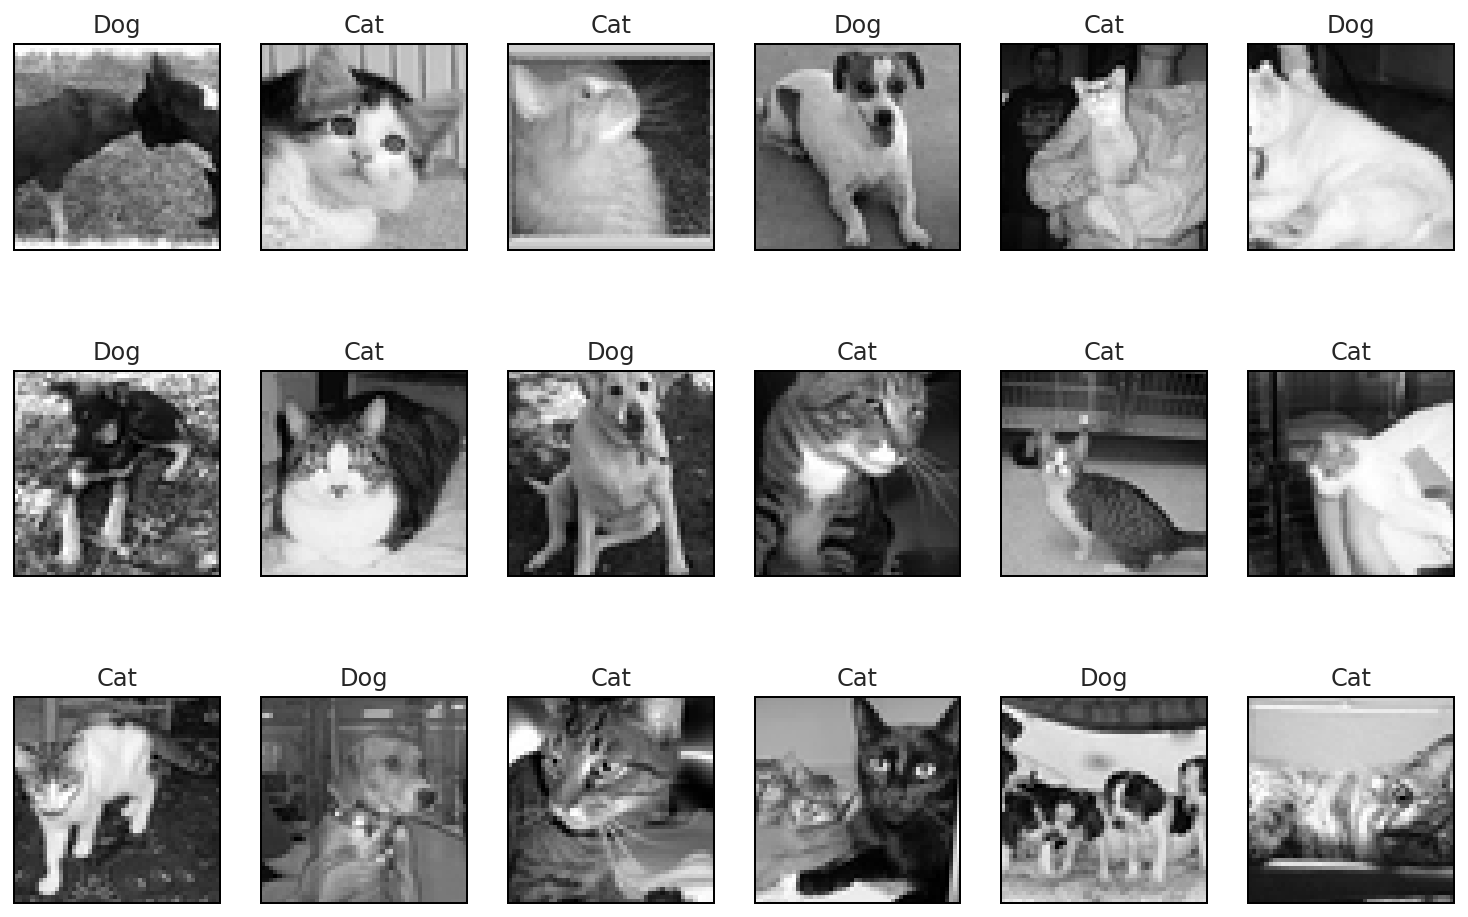

Raw:
 [204 206 209 ...,  16  12   9]
Normalized:
 [ 0.60000002  0.6156863   0.63921571 ..., -0.87450981 -0.90588236
 -0.92941177]


In [27]:
idx = np.random.choice(data_raw.shape[0], 18, replace=False)
some_images = data_raw[idx]
some_labels = np.vectorize(lambda x: 'Dog' if x else 'Cat')(target[idx])
plot_gallery(some_images, some_labels, image_size)
print('Raw:\n',data_raw[0])
print('Normalized:\n',data[0])

In [29]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

evaluation_function = roc_auc_score
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, random_state=None, shuffle=False)

In [30]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, BatchNormalization, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import Callback

class ConvolutionalNeuralNet:
    def __init__(
        self,
        input_shape,
        n_filters,
        dense_sizes,
        output_size,
        
        batch_normalize = True,

        layer_activation='relu',
        final_activation='softmax',

        loss='mean_squared_error', 
        optimizer='rmsprop', 
        metrics=['binary_accuracy'],

        batch_size=32,
        epochs=50,
        shuffle=False,
        verbose=2
    ):
        self.input_shape = input_shape
        self.n_filters = n_filters
        self.dense_sizes = dense_sizes
        self.output_size = output_size
        
        self.batch_normalize = batch_normalize
        
        self.layer_activation = layer_activation
        self.final_activation = final_activation
        
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics
        
        self.batch_size = batch_size
        self.epochs = epochs
        self.shuffle = shuffle
        self.verbose = verbose
        
        self._make_model()
    
    def _make_convolution_layers(self):
        self._model.add(
            Reshape(
                (1, self.input_shape[0], self.input_shape[1]), 
                input_shape=(1, self.input_shape[0]*self.input_shape[1])
            )
        )
                       
        for filters in self.n_filters:
                
            # Add a single convolution layer
            self._model.add(
                Conv2D(
                    filters=filters,
                    kernel_size=(3,3),
                    padding='same',
                    activation=self.layer_activation
                )
            )
            # Add batch normalization to the convolution layer
            if self.batch_normalize:
                self._model.add(
                    BatchNormalization(axis=1)
                )
            # Pool the layer
            self._model.add(
                MaxPooling2D(pool_size=(2,2), data_format='channels_first')
            )
        
        self._model.add(Flatten())
                
    def _make_dense_layers(self):
    
        for size in self.dense_sizes:
            self._model.add(
                Dense(size, activation=self.layer_activation)
            )
            if self.batch_normalize:
                self._model.add(
                    BatchNormalization(axis=1)
                )
    
        self._model.add(
            Dense(self.output_size, activation=self.final_activation)
        )
                
    def _make_model(self):
        self._model = Sequential()
        
        self._make_convolution_layers()
        self._make_dense_layers()
        
        self._model.compile(
            loss=self.loss,
            optimizer=self.optimizer,
            metrics=self.metrics
        )
                
    def fit(self, X_raw, y):
        # Using keras Callbacks to hook into end of epoch
        # for per-epoch evaluation statistics collection
        # [CITE] https://github.com/fchollet/keras/issues/2548#issuecomment-215664770
        self.epoch_log_ = []
        net = self
        class AnalyticsCallback(Callback):
            def on_epoch_end(self, epoch, logs={}):
                net.epoch_log_.append(logs)
        
        X = np.matrix(X_raw.tolist())
        X = np.expand_dims(X, axis=1)
        self._model.fit(
            X, y, 
           batch_size=self.batch_size,
           epochs=self.epochs,
           shuffle=self.shuffle,
           verbose=self.verbose,
           callbacks=[AnalyticsCallback()]
        )
                       
    def predict(self, X_raw):
        X = np.matrix(X_raw.tolist())
        X = np.expand_dims(X, axis=1)
        return self._model.predict(X)
    
    @staticmethod
    def one_hot_output(y_hat_raw):
        # predict() outputs floats. We want one-hot in most cases
        y_hat = np.zeros(y_hat_raw.shape, dtype=np.int)
        y_hat[np.arange(y_hat_raw.shape[0]), y_hat_raw.argmax(1)] = 1
        return y_hat

Using TensorFlow backend.


In [31]:
# we store the networks in this array
# so we can grab their epoch_log_ properties
# wherein we persist the per-epoch accuracy
# so we can make pretty charts.
def cross_validation_step(ModelClass, indices, parameters): 
    train_index, test_index = indices
    X_train = data[train_index]
    y_train = np.asarray(pd.get_dummies(target[train_index]))
    X_test = data[test_index]
    y_test = target[test_index]
    
    # training
    clf = ModelClass(**parameters)
    clf.fit(X_train, y_train)
    
    # testing
    y_hat_raw = clf.predict(X_test)
    y_hat = ModelClass.one_hot_output(y_hat_raw)
    score = evaluation_function(pd.get_dummies(y_test), y_hat)
    return score,clf

def cross_validation(ModelClass, cv, parameters):
    cv_indices = cv.split(data, target)
    scores = np.empty(n_splits)
    nets = [None]*n_splits
    
    if 'epochs' in parameters:
        total_epochs = n_splits*parameters['epochs']
        print(
            f'Performing {n_splits}-fold Stratified cross validation with {parameters["epochs"]} '
            f'epochs each ({total_epochs} epochs total)'
        )
        if total_epochs > 80:
            print('‚òïÔ∏è you may want to grab a coffee')
        
    # I promise I tried parallelizing this 
    # but Tensorflow didn't like it.
    #
    # (tried threading.Thread and multiprocess.Pool)
    for i,indices in enumerate(cv_indices):
        print(f'Split {i+1:2} of {n_splits:2} {"‚òïÔ∏è"*(i+1)}')
        scores[i],nets[i] = cross_validation_step(ModelClass, indices, parameters)
        
    return scores,nets

def get_logs_from_nets(nets, parameter_name):
    return [[epoch[parameter_name] for epoch in net.epoch_log_] for net in nets]

In [36]:
'''
1)  n_filters=[32,64,64,128], #128 64 32
    dense_sizes=[256,256]
    
    
Results:
1) Accuracy (ROC): 0.67 (¬±0.03)
'''

params = dict(
    input_shape=image_size,

    n_filters=[32,64,64,256,256],
    dense_sizes=[128,128],

    output_size=2,

    loss='binary_crossentropy', 
    optimizer='Nadam', 
    metrics=['binary_accuracy'],

    batch_size=32,
    epochs=40,
    shuffle=True,
    verbose=2 # one line per epoch
)

In [37]:
%%time

scores, nets = cross_validation(ConvolutionalNeuralNet, cv, params)

Performing 5-fold Stratified cross validation with 40 epochs each (200 epochs total)
‚òïÔ∏è you may want to grab a coffee
Split  1 of  5 ‚òïÔ∏è
Epoch 1/40
10s - loss: 0.6831 - binary_accuracy: 0.5875
Epoch 2/40
9s - loss: 0.6319 - binary_accuracy: 0.6458
Epoch 3/40
9s - loss: 0.6004 - binary_accuracy: 0.6791
Epoch 4/40
9s - loss: 0.5725 - binary_accuracy: 0.7016
Epoch 5/40
9s - loss: 0.5534 - binary_accuracy: 0.7184
Epoch 6/40
9s - loss: 0.5354 - binary_accuracy: 0.7279
Epoch 7/40
9s - loss: 0.5171 - binary_accuracy: 0.7435
Epoch 8/40
9s - loss: 0.4927 - binary_accuracy: 0.7608
Epoch 9/40
9s - loss: 0.4706 - binary_accuracy: 0.7731
Epoch 10/40
9s - loss: 0.4436 - binary_accuracy: 0.7913
Epoch 11/40
9s - loss: 0.4152 - binary_accuracy: 0.8078
Epoch 12/40
9s - loss: 0.3820 - binary_accuracy: 0.8281
Epoch 13/40
9s - loss: 0.3512 - binary_accuracy: 0.8464
Epoch 14/40
9s - loss: 0.3191 - binary_accuracy: 0.8609
Epoch 15/40
9s - loss: 0.2844 - binary_accuracy: 0.8808
Epoch 16/40
9s - loss: 0

9s - loss: 0.0961 - binary_accuracy: 0.9645
Epoch 26/40
9s - loss: 0.0834 - binary_accuracy: 0.9689
Epoch 27/40
9s - loss: 0.0913 - binary_accuracy: 0.9663
Epoch 28/40
9s - loss: 0.0791 - binary_accuracy: 0.9712
Epoch 29/40
9s - loss: 0.0736 - binary_accuracy: 0.9717
Epoch 30/40
9s - loss: 0.0840 - binary_accuracy: 0.9685
Epoch 31/40
9s - loss: 0.0642 - binary_accuracy: 0.9764
Epoch 32/40
9s - loss: 0.0763 - binary_accuracy: 0.9725
Epoch 33/40
9s - loss: 0.0661 - binary_accuracy: 0.9752
Epoch 34/40
9s - loss: 0.0553 - binary_accuracy: 0.9790
Epoch 35/40
9s - loss: 0.0571 - binary_accuracy: 0.9791
Epoch 36/40
9s - loss: 0.0472 - binary_accuracy: 0.9827
Epoch 37/40
9s - loss: 0.0581 - binary_accuracy: 0.9782
Epoch 38/40
9s - loss: 0.0466 - binary_accuracy: 0.9837
Epoch 39/40
9s - loss: 0.0493 - binary_accuracy: 0.9820
Epoch 40/40
9s - loss: 0.0490 - binary_accuracy: 0.9817
Split  5 of  5 ‚òïÔ∏è‚òïÔ∏è‚òïÔ∏è‚òïÔ∏è‚òïÔ∏è
Epoch 1/40
10s - loss: 0.6665 - binary_accuracy: 0.6041
Epoch 2/40
9s 



Accuracy (ROC): 0.94 (¬±0.05)




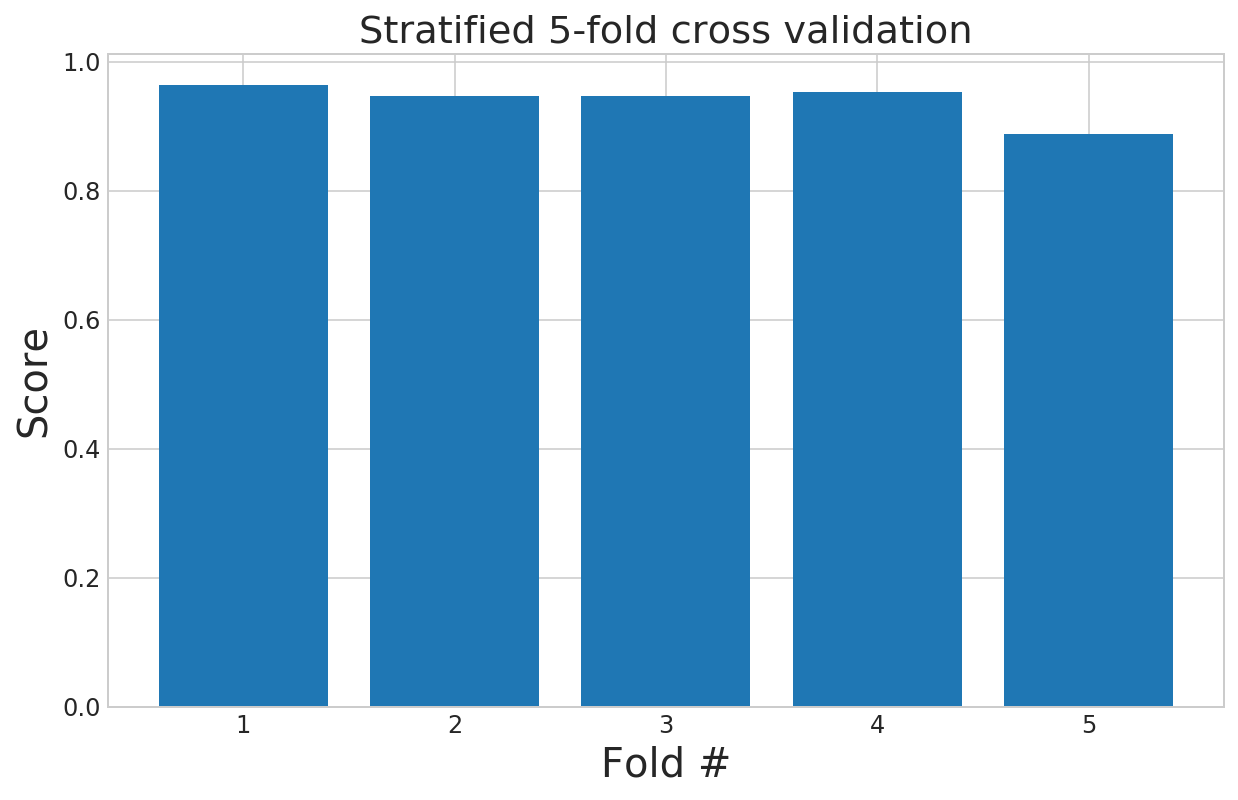

In [60]:
ax = plt.bar(range(len(scores)),scores)
plt.xticks(range(n_splits),range(1,n_splits+1))
plt.title(f'Stratified {n_splits}-fold cross validation')
plt.xlabel('Fold #')
plt.ylabel('Score')

print(
    '\n','='*50,'Accuracy (ROC): %0.2f (¬±%0.2f)' % (np.asarray(scores).mean(), np.asarray(scores).std() * 2),
    '='*50,'\n',sep='\n'
)

In [57]:
# https://gist.github.com/phrz/98045738d182dd75d1eed74470b9b2ef

def average_line(data, plot_quartiles=True, color='#016d91'):
    '''
    Given 2D data where columns are samples and rows are classes/time series, 
    plot an average line and surrounding quartile area 
    (like a continuous box plot)
    '''
    averages = np.average(data,axis=0)
    x = np.arange(1, len(averages)+1)
    plt.plot(x, averages, color=color)

    if plot_quartiles:
        lower = np.percentile(accs, 25, axis=0)
        upper = np.percentile(accs, 75, axis=0)
        plt.fill_between(x, lower, upper, color=color, alpha='0.3', linewidth=0)

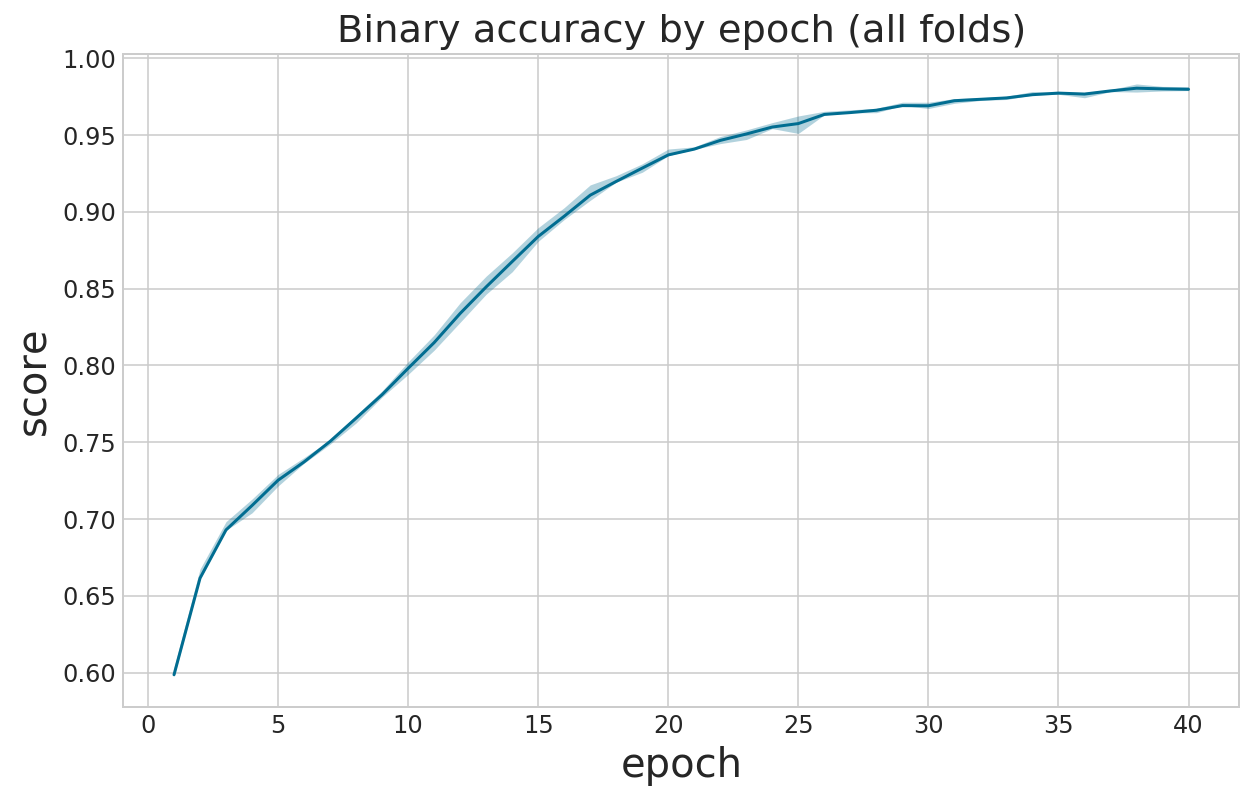

In [63]:
average_line(accs)
plt.xlabel('epoch')
plt.ylabel('score')
plt.title('Binary accuracy by epoch (all folds)');